Read header and print it

In [1]:
from flopa.io.ptuio.reader import TTTRReader

reader = TTTRReader('../tests/data/LSM/B16_KO1_10.ptu')
for key, value in reader.header.tags.items():
    print(f'{key}: {value}')

Measurement_SubMode = reader.header.tags.get("Measurement_SubMode")

if Measurement_SubMode<1:
    print("Not an image. You must set scanning configuration.")
else:
    ImgHdr_PixX = reader.header.tags.get("ImgHdr_PixX")
    ImgHdr_PixY = reader.header.tags.get("ImgHdr_PixY")

# This file is recorded in point mode - scanner information is not in the header, but the markers are recorded anyway

File_GUID: {2B1AFF98-5B5D-4001-A1F3-9A5ED757EC3C}
File_CreatingTime: 2024-10-23 10:26:22.669000
Measurement_SubMode: 0
File_Comment: 1024x1024px, 
bi-di
dwell 2.06us
16 line avg
3 frames
zoom 1.5
40x WI
pwr 9% (12mW)
TTResult_StopReason: 1
Fast_Load_End: <Empty>
CreatorSW_Name: SymPhoTime 64
CreatorSW_Version: 2.7
CreatorSW_SVNBuild: 5615
CreatorSW_Modules: 0
ImgHdr_Dimensions: 1
ImgHdr_Ident: 3
Measurement_Mode: 3
HW_Type: HydraHarp
HW_SerialNo: 1027371
HW_Version: 2.0
HW_ExternalRefClock: False
HW_Modules: 4
HWModule_TypeCode[0]: 1000
HWModule_VersCode[0]: 51052545
HWModule_TypeCode[1]: 1010
HWModule_VersCode[1]: 33554954
HWModule_TypeCode[2]: 1040
HWModule_VersCode[2]: 18153994
HWModule_TypeCode[3]: 1040
HWModule_VersCode[3]: 18153994
HW_Markers: 4
HWMarkers_Enabled[0]: True
HWMarkers_RisingEdge[0]: False
HWMarkers_Enabled[1]: True
HWMarkers_RisingEdge[1]: True
HWMarkers_Enabled[2]: True
HWMarkers_RisingEdge[2]: False
HWMarkers_Enabled[3]: True
HWMarkers_RisingEdge[3]: False
HWMarke

Get some useful constants from the header

In [2]:
from flopa.io.ptuio.utils import estimate_tcspc_bins

wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=10) # if buffer = 0, channel overflow can be expected


In [3]:
from flopa.io.ptuio.decoder import T3OverflowCorrector
from flopa.io.ptuio.reconstructor import ScanConfig
from flopa.io.ptuio.reconstructor import ImageReconstructor

corrector = T3OverflowCorrector(wraparound=wrap)

cfg = ScanConfig(
    bidirectional=True, 
    bidirectional_phase_shift= 0.00677,
    frames= 3,
    lines=1024, 
    pixels=1024, 
    line_accumulations= (16,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        tcspc_channels= tcspc_bins,
        outputs=['photon_count']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()


TCSPC channel overflow detected! Max channel: 20569
Channel overflow detected! Max channel: 3


By the way: bin by 2x2 pixels during reconstruction - this can be achieved simply by user input

In [4]:
cfg = ScanConfig(
    bidirectional=True, 
    bidirectional_phase_shift= 0.00677,
    frames= 3,
    lines=512, 
    pixels=512, 
    line_accumulations= (32,),
    max_detector=2
    )

reconstructor = ImageReconstructor(
        config=cfg, 
        tcspc_channels= tcspc_bins,
        outputs=['photon_count','tcspc_histogram']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()
# image = result.photon_count
decay = result.tcspc_histogram
dtime = result.tcspc_channel * tcspc_resolution * 1e9


TCSPC channel overflow detected! Max channel: 20569
Channel overflow detected! Max channel: 3


Original dataset coords:  Coordinates:
  * frame          (frame) uint32 12B 0 1 2
  * sequence       (sequence) uint8 1B 0
  * line           (line) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * pixel          (pixel) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * detector       (detector) uint8 2B 0 1
  * tcspc_channel  (tcspc_channel) uint16 802B 0 1 2 3 4 ... 396 397 398 399 400
Aggregated dataset coords:  Coordinates:
  * sequence       (sequence) uint8 1B 0
  * line           (line) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * pixel          (pixel) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * detector       (detector) uint8 2B 0 1
  * tcspc_channel  (tcspc_channel) uint16 802B 0 1 2 3 4 ... 396 397 398 399 400
  * frame          (frame) uint32 4B 0


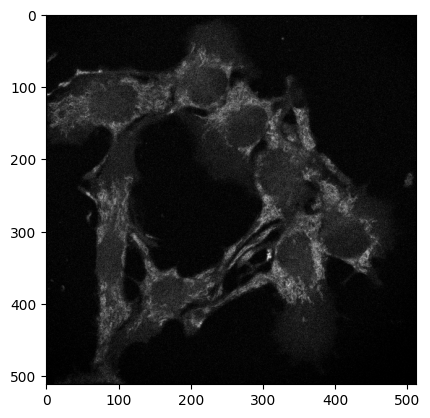

In [5]:
from flopa.io.ptuio.utils import aggregate_dataset
import matplotlib.pyplot as plt
result_sum = aggregate_dataset(result,dims=['frame'])

print("Original dataset coords: ", result.coords)
print("Aggregated dataset coords: ", result_sum.coords)

actual_slice = result_sum.photon_count.isel(frame=0,detector=0,sequence=0)
fig, ax = plt.subplots()
ax.imshow(actual_slice, cmap='grey')
plt.show()


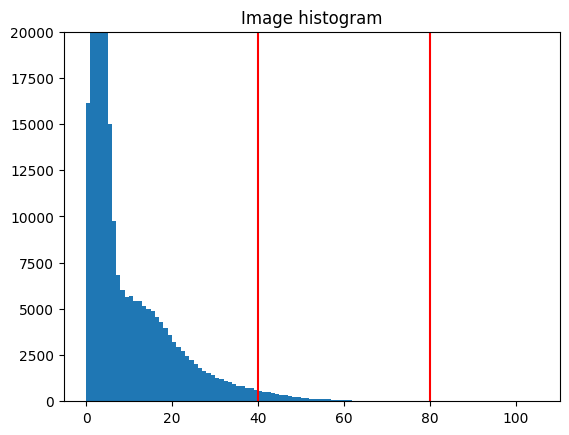

In [6]:
threshold = [40,80]


fig, ax = plt.subplots()
image_sum_ravel = actual_slice.data.ravel()
ax.hist(image_sum_ravel,bins=int(max(image_sum_ravel)))
ax.set_ylim([0, 2e4])
ax.set_title('Image histogram')
ax.vlines(x=threshold,colors='red', ymin=0, ymax=1e5)
plt.show()


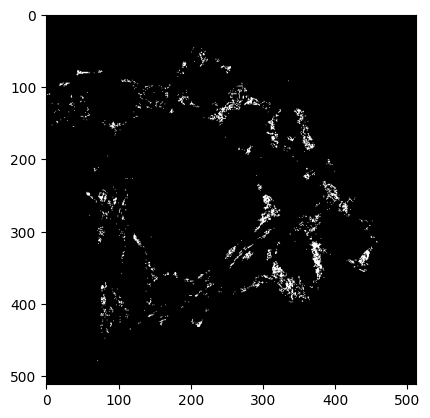

In [7]:
image_mask = ((actual_slice > threshold[0]) & (actual_slice < threshold[1]))
image_mask = image_mask.values # make sure it is numpy
fig, ax = plt.subplots()
ax.imshow(image_mask,cmap='gray')
plt.show()

Read decay just from the masked area

In [21]:
cfg = ScanConfig(
    bidirectional=True, 
    bidirectional_phase_shift= 0.00677,
    frames= 3,
    lines=512, 
    pixels=512, 
    line_accumulations= (32,),
    max_detector=2
    )


reconstructor = ImageReconstructor(
        config=cfg, 
        tcspc_channels= tcspc_bins,
        roi_mask = image_mask,
        outputs=['tcspc_histogram','photon_count']
        )

for chunk in reader.iter_chunks():
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()
decay_masked = result.tcspc_histogram



TCSPC channel overflow detected! Max channel: 20569
Channel overflow detected! Max channel: 3


Check if the masking actually works

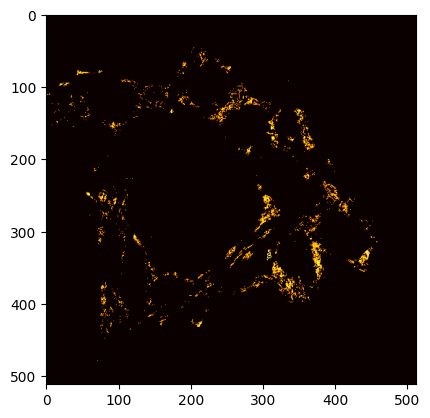

In [24]:
result_sum = aggregate_dataset(result,dims=['frame'])

actual_slice = result_sum.photon_count.isel(frame=0,detector=0,sequence=0)
fig, ax = plt.subplots()
ax.imshow(actual_slice, cmap='hot')
plt.show()


Plot the decays

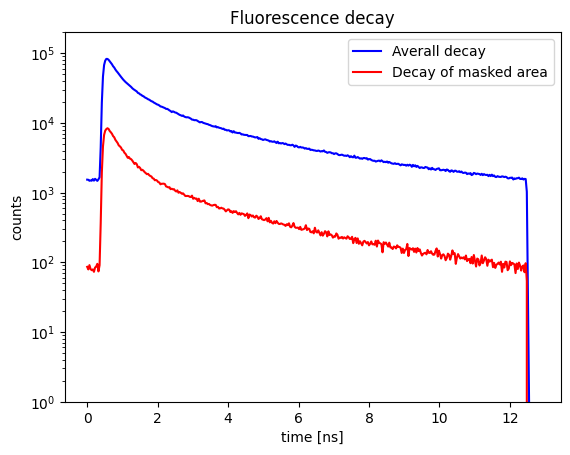

In [25]:
decay_sum = decay.coarsen(frame = 3, detector = 2,sequence=1).sum().squeeze()
decay_masked_sum = decay_masked.coarsen(frame = 3, detector = 2, sequence = 1).sum().squeeze()


fig, ax = plt.subplots()
ax.semilogy(dtime.data, decay_sum.data, 'b-', label = 'Averall decay')
ax.semilogy(dtime.data, decay_masked_sum.data, 'r-', label = 'Decay of masked area')
ax.set_title('Fluorescence decay')
ax.set_ylabel('counts')
ax.set_xlabel('time [ns]')
ax.set_ylim([1, 2e5])
plt.legend()
plt.show()

Plot phasors

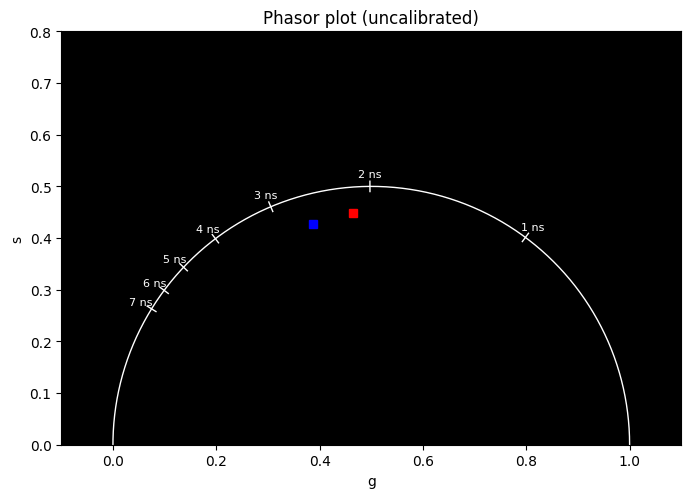

In [26]:
from flopa.io.ptuio.utils import draw_unitary_circle, get_phasor_from_decay


phasor_all = get_phasor_from_decay(decay=decay_sum.data,tcspc_resolution=tcspc_resolution,sync_rate=repetition_rate)
phasor_masked = get_phasor_from_decay(decay=decay_masked_sum.data,tcspc_resolution=tcspc_resolution,sync_rate=repetition_rate)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(phasor_all.real,phasor_all.imag, 'bs')
ax.plot(phasor_masked.real,phasor_masked.imag, 'rs')
ax.set_xlabel('g')
ax.set_ylabel('s')
ax.set_title('Phasor plot (uncalibrated)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_facecolor('black')

draw_unitary_circle(ax=ax,sync_rate=repetition_rate)
plt.show()

# background shifts the phasor towards longer lifetime